<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#Figure-S2" data-toc-modified-id="Figure-S2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure S2</a></span></li></ul></div>

In [8]:
import xarray as xr
import sys
import random
from scipy import stats
import glob
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
from palettable.scientific.diverging import Roma_20
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark --iversions -v -m

xarray     0.16.0
numpy      1.17.3
matplotlib 3.1.2
CPython 3.6.9
IPython 7.1.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-122-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [3]:
func = lambda x: x.split('comp_')[1].split('_{}days'.format(time_scale))[0]


In [4]:
its = 10000
DJF_bool = 'DJF'                                                          
DJF_bool = '_{}only'.format(DJF_bool) 
cesta_root = '/mnt/4data/CMAM/0A.daily/'
cesta = f'{cesta_root}composites_woSSW{DJF_bool}/'
print(cesta)
time_scale = '20'
lw = 2
comp_name_ls = ['himalayas', 'eastasia', 'westamer',]
size_dict = {'20': [45,74,36], '30': [38,66,35]}
line_width = 5
box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
box2 = sgeom.box(minx=110, maxx=145, miny=30, maxy=48)
box3 = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
boxes = [box, box2, box3]
projection = ccrs.PlateCarree(central_longitude=0)#Robinson()# Orthographic(180, 90)
proj_str = str(projection).split('crs.')[1].split(' object')[0]

/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/


# Data loading

In [5]:
var = 'tauu'
what = 'anomalies'
if var == 'tauu':
    long_name = r'Surface Downward Eastward Wind Stress'
elif var == 'tauv':
    long_name = r'Surface Downward Northward Wind Stress'

lev_sys_fo = ''
lev_sys_fi = ''
units = 'Pa'

    
outfile_name = '{}{}{}_pvalues_from{}_comp_*_{}days.nc'.format(cesta, var, lev_sys_fi, its, time_scale,)
print(outfile_name)
outfile_name_ls = glob.glob(outfile_name)
ds_pv = xr.open_mfdataset(outfile_name_ls, concat_dim='e_type', combine = 'nested')#, parallel = True)
ds_pv['e_type'] = list(map(func, outfile_name_ls))
ds_pv = ds_pv.sel(lag = 0)

comp_file = '{}{}{}_{}_comp_*_{}days.nc'.format(cesta, var, lev_sys_fi, what, time_scale)
comp_file_ls = glob.glob(comp_file)
ds_comp = xr.open_mfdataset(comp_file_ls, concat_dim='e_type', combine = 'nested')
ds_comp['e_type'] = list(map(func, comp_file_ls))
ds_comp = ds_comp.sel(lag = 0)
ds_comp[var].attrs['units'] = units
ds_comp[var].attrs['long_name'] = long_name

comp_file = f'{cesta_root}/{var}/{lev_sys_fo}{var}_climatology_woSSW.nc'
print(comp_file)
sel_dict = dict(month = [12, 1, 2])
ds_comp2 = xr.open_dataset(comp_file).sel(**sel_dict).mean('month')[var]
ds_comp2

/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/tauu_pvalues_from10000_comp_*_20days.nc
/mnt/4data/CMAM/0A.daily//tauu/tauu_climatology_woSSW.nc


<xarray.DataArray 'tauu' (lat: 48, lon: 96)>
array([[-4.3324186e-03, -3.8874131e-03, -3.0327735e-03, ...,
        -8.1250547e-03, -1.2215470e-02, -7.4150064e-03],
       [-5.7721734e-03,  9.9215759e-03,  3.4460919e-03, ...,
        -7.2325491e-03, -2.5435183e-03, -2.3324771e-03],
       [-8.6404467e-03, -2.9324958e-04, -3.7713372e-04, ...,
        -3.4423443e-03, -1.2611783e-03,  5.6589511e-03],
       ...,
       [-1.8564004e-05, -1.0220701e-04, -7.3502879e-03, ...,
         8.2119327e-04,  5.4209242e-05,  2.0100599e-06],
       [-2.1296773e-06, -2.2642573e-06, -2.4572942e-06, ...,
         1.6824836e-04, -3.7447608e-05, -1.7241526e-05],
       [-5.8370474e-06, -5.9138365e-06, -5.9882273e-06, ...,
        -4.9491241e-06, -5.3082235e-06, -5.7387028e-06]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16

# Figure S2

tauu_anomalies_allwclim_20days_wsignificancefrom10000_PlateCarree_DJFonly.pdf


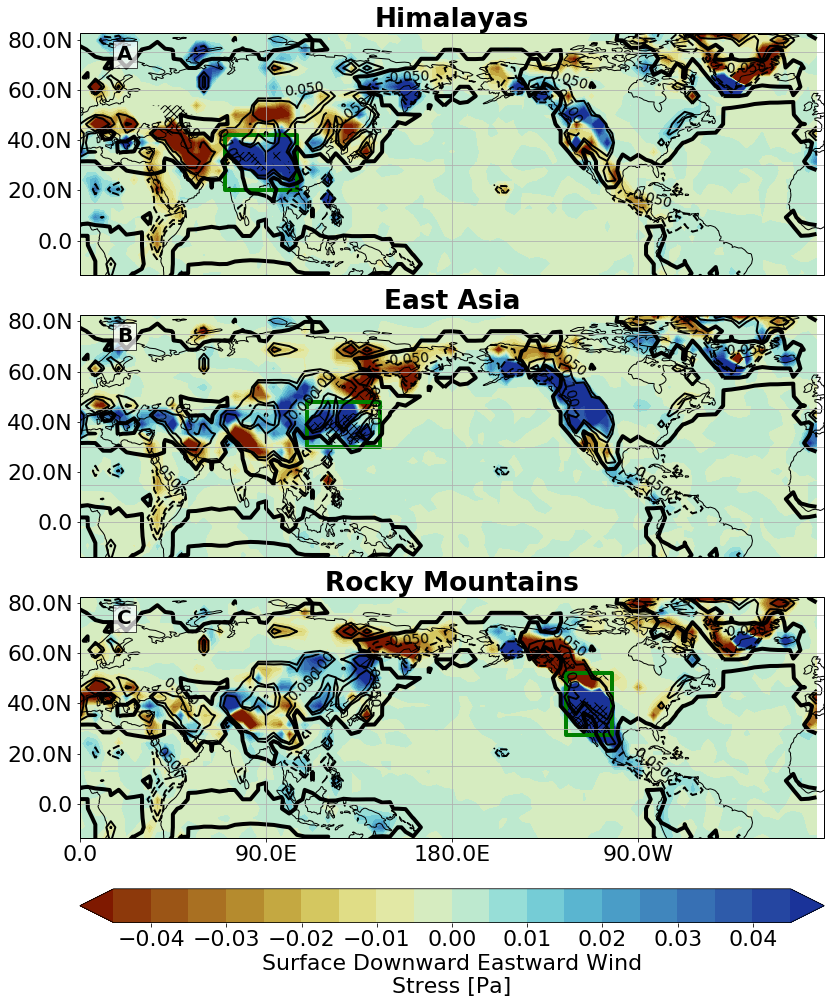

In [11]:
#fig = plt.figure(figsize=(15,9))
plt.rcParams.update({'font.size': 22})
projection = ccrs.PlateCarree(central_longitude=180)
cmap = Roma_20.mpl_colormap
p = (ds_comp[var].sel(e_type = comp_name_ls)).plot.contourf(col = 'e_type', levels = 21, robust = True, \
                                                          col_wrap = 1, \
                                                          transform=ccrs.PlateCarree(), \
                                                          aspect=ds_comp.dims['lon']/ds_comp.dims['lat'], \
                                                          size = 5, \
                                                          cmap = cmap, \
                                                          subplot_kws={'projection': projection}, \
                                                          cbar_kwargs = {'orientation': 'horizontal', \
                                                                         'pad': 0.05})

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
titles = ['Himalayas', 'East Asia','Rocky Mountains']
label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

for i,(ax, sel_dict, box, label) in enumerate(zip(p.axes.flat, p.name_dicts.flat, boxes, label_ls)):
    #print(sel_dict)
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize = 20, 
              fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
    ax.coastlines()
    ax.gridlines(xlocs = [-180, -90, 0, 90, 180])
    ax.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter(number_format='.1f', \
                                      degree_symbol='')        
    ax.yaxis.set_major_formatter(lat_formatter)

    if i == 2:
        ax.set_xticks([-90, 0, 90, 180], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.1f', \
                                       degree_symbol='', \
                                       dateline_direction_label=True)    
        ax.xaxis.set_major_formatter(lon_formatter)
        
    
    CS = (ds_comp2).plot.contour(levels = [-0.1,-0.05,0.05,0.1], \
                                     colors = 'k', \
                                     ax = ax, linewidths = lw, \
                                     transform=ccrs.PlateCarree())
    plt.clabel(CS, inline=1, fontsize=14)
    ds_comp2.plot.contour(levels = [0], colors = 'k', \
                                                ax = ax, linewidths = lw*2, \
                                                transform=ccrs.PlateCarree())
    
    #, fmt = fmt)

    if proj_str == 'PlateCarree':
        ax.set_extent([0, 270, -10, 80])#ax.set_extent([-180, 180, -10, 80])
        ax.set_aspect('auto')

    plot_kwargs2 = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False, transform=ccrs.PlateCarree())
    temp = ds_pv[var].sel(**sel_dict)#*24*3600

    temp.plot.contourf(ax = ax, **plot_kwargs2)
    plot_kwargs2['levels'] = [0,0.01]
    plot_kwargs2['hatches'] = ['////',None]

    temp.plot.contourf(ax = ax, **plot_kwargs2) #ax.contourf(temp.lon, temp.lat, temp.values, **plot_kwargs2)
    ax.set_title(titles[i], fontdict = dict(fontweight = 'bold'))
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])

    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    
out_fig = '{}_{}_allwclim_{}days_wsignificancefrom{}_{}{}.pdf'.format(var, \
                                                                    what, time_scale, its, \
                                                                    proj_str, DJF_bool)
print(out_fig)
plt.savefig(out_fig, bbox_inches='tight')